<a href="https://colab.research.google.com/github/btaruns22/Reel-Success-Machine-Learning-Analysis-for-Movie-Financial-and-Rating-Performances/blob/main/DS4400_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DS4400 Final Project
Valerie Jap, Tarun Badarvada, Julian Getsey

For this project you will need import the data from Kaggle's The Movies Dataset. Here is the link: [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset)

Necessary Imports

In [ ]:
# Working with Dataframes using Pandas and Numpy
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Neural Network with PyTorch
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Importing Encoders, Scalers, ML models, etc.
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

# Importing Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay





Linear Regression

In [ ]:
# Load the dataset
df = pd.read_csv("movies_metadata.csv")

# Convert 'genre' column string to list
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Extract genre names and assign them to a new column
df['genre_list'] = df['genres'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

# Include new features in the preprocessing
df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1)

# Ensure numerical columns are converted and NA values handled
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce').fillna(0)
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce').fillna(0)
df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce').fillna(0)

df = df[['budget', 'vote_average', 'revenue', 'popularity', 'belongs_to_collection', 'runtime', 'vote_count', 'genre_list']].dropna()

# Convert 'budget' to numeric, filtering out invalid or zero values
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

# Initialize the MultiLabelBinarizer for 'genre_list'
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_, index=df.index)

# Drop 'genre_list' as its one-hot encoded version will be used
df.drop(['genre_list'], axis=1, inplace=True)

# Concatenate the original DataFrame with the new 'genre_dummies' DataFrame
df = pd.concat([df, genre_dummies], axis=1)

print(df.head())


<ipython-input-47-671b5cb62dfd>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("movies_metadata.csv")


     budget  vote_average      revenue  popularity  belongs_to_collection  \
0  30000000           7.7  373554033.0   21.946943                      1   
1  65000000           6.9  262797249.0   17.015539                      0   
3  16000000           6.1   81452156.0    3.859495                      0   
5  60000000           7.7  187436818.0   17.924927                      0   
8  35000000           5.5   64350171.0    5.231580                      0   

   runtime  vote_count  Action  Adventure  Animation  ...  History  Horror  \
0     81.0      5415.0       0          0          1  ...        0       0   
1    104.0      2413.0       0          1          0  ...        0       0   
3    127.0        34.0       0          0          0  ...        0       0   
5    170.0      1886.0       1          0          0  ...        0       0   
8    106.0       174.0       1          1          0  ...        0       0   

   Music  Mystery  Romance  Science Fiction  TV Movie  Thriller  War

In [ ]:
# Define features (X) and target (y)
X = pd.concat([df[['budget', 'vote_average', 'popularity', 'belongs_to_collection', 'runtime', 'vote_count']], genre_dummies], axis=1)
y = df['revenue']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on training set for R² score
y_train_pred = model.predict(X_train)

# Calculate R² score for training set
r2_train = r2_score(y_train, y_train_pred)
print(f"R² Score for Training Set: {r2_train}")

# Predict on test set for R² score
y_test_pred = model.predict(X_test)

# Calculate R² score for test set
r2_test = r2_score(y_test, y_test_pred)
print(f"R² Score for Testing Set: {r2_test}")


R² Score for Training Set: 0.7496219080754949
R² Score for Testing Set: 0.6978066009227275


In [ ]:
# Coefficients
feature_names = X_train.columns  # Get the feature names from the training set
coefficients = model.coef_  # Extract the coefficients from the model

# Pair feature names with coefficients
feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Print the feature coefficients
print(feature_coefficients)

                  Feature   Coefficient
0                  budget  1.678158e+00
1            vote_average -2.752037e+05
2              popularity  9.423242e+05
3   belongs_to_collection  5.132905e+07
4                 runtime  2.936999e+05
5              vote_count  6.326577e+04
6                  Action -6.662196e+06
7               Adventure  1.360435e+07
8               Animation  1.972467e+07
9                  Comedy  3.708092e+06
10                  Crime -1.066885e+07
11            Documentary  2.515511e+07
12                  Drama -3.828340e+06
13                 Family  1.855627e+07
14                Fantasy -4.486996e+06
15                Foreign  1.269362e+07
16                History -9.077396e+06
17                 Horror  6.867977e+05
18                  Music  8.818367e+06
19                Mystery -3.544416e+06
20                Romance  1.907517e+07
21        Science Fiction -3.106362e+07
22               TV Movie  7.931972e+07
23               Thriller -4.858329e+06


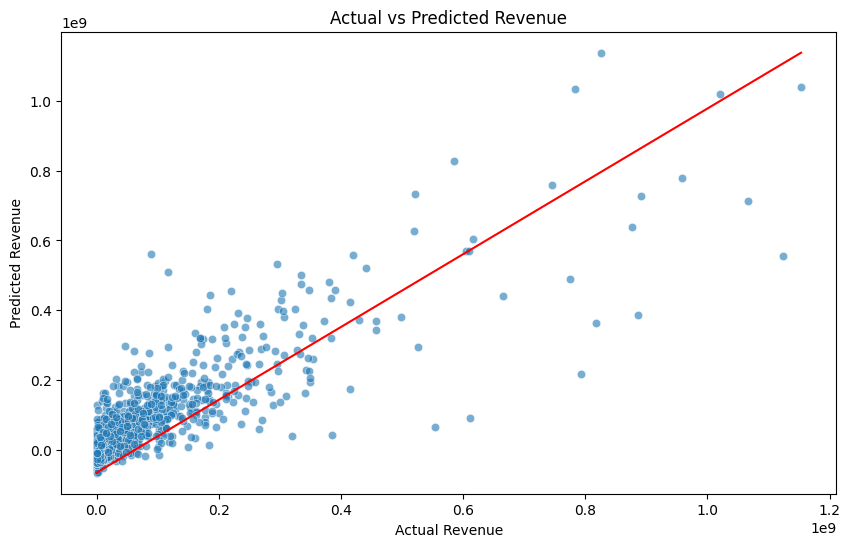

In [ ]:
# Actual vs Predicted scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test_pred), max(y_test_pred)], color='red')  # Line of best fit
plt.title('Actual vs Predicted Revenue')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.show()

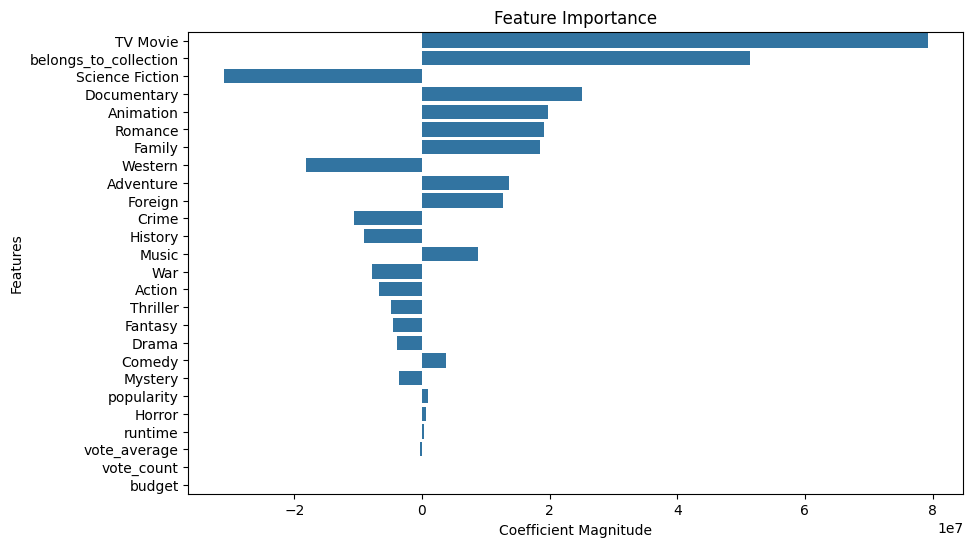

In [ ]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
feature_importance = feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.show()

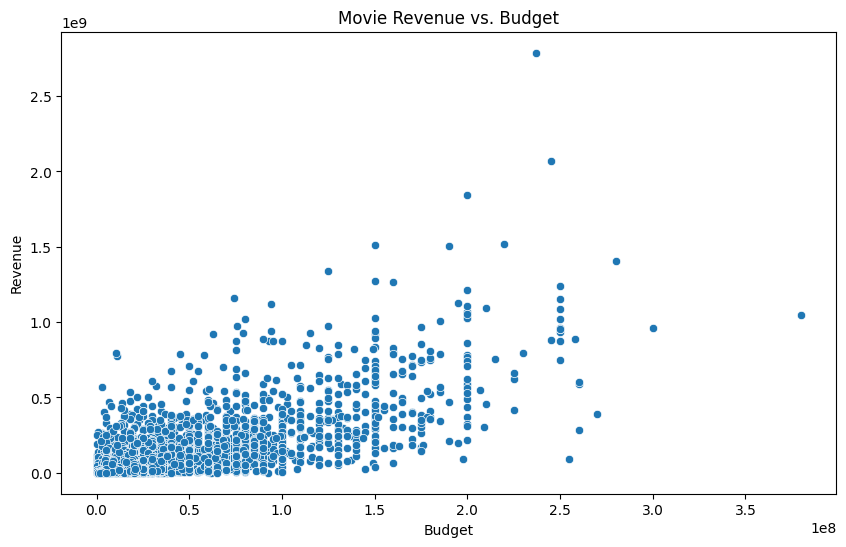

In [ ]:
# Revenue vs. Budget plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='budget', y='revenue')
plt.title('Movie Revenue vs. Budget')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

<ipython-input-54-4600af7a1528>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='vote_average', y='revenue', ci=None)


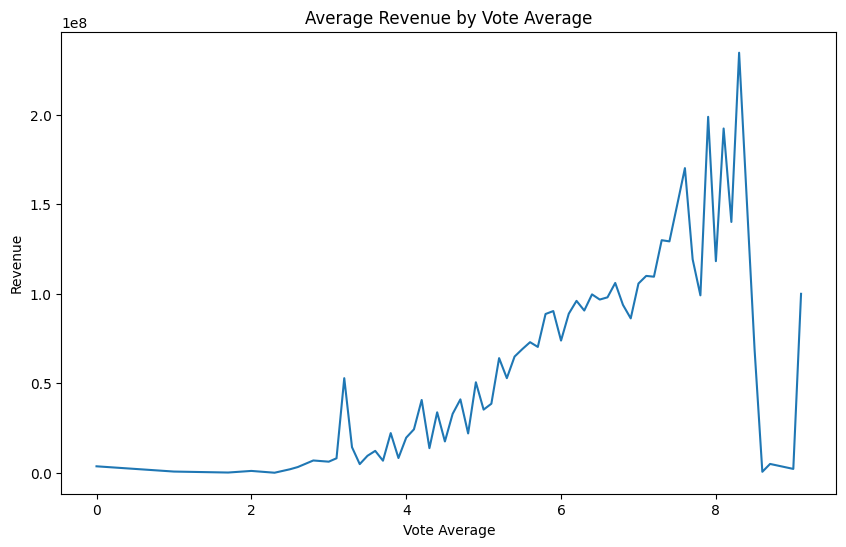

In [ ]:
# Average Revenue vs. Vote Average
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='vote_average', y='revenue', ci=None)
plt.title('Average Revenue by Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Revenue')
plt.show()


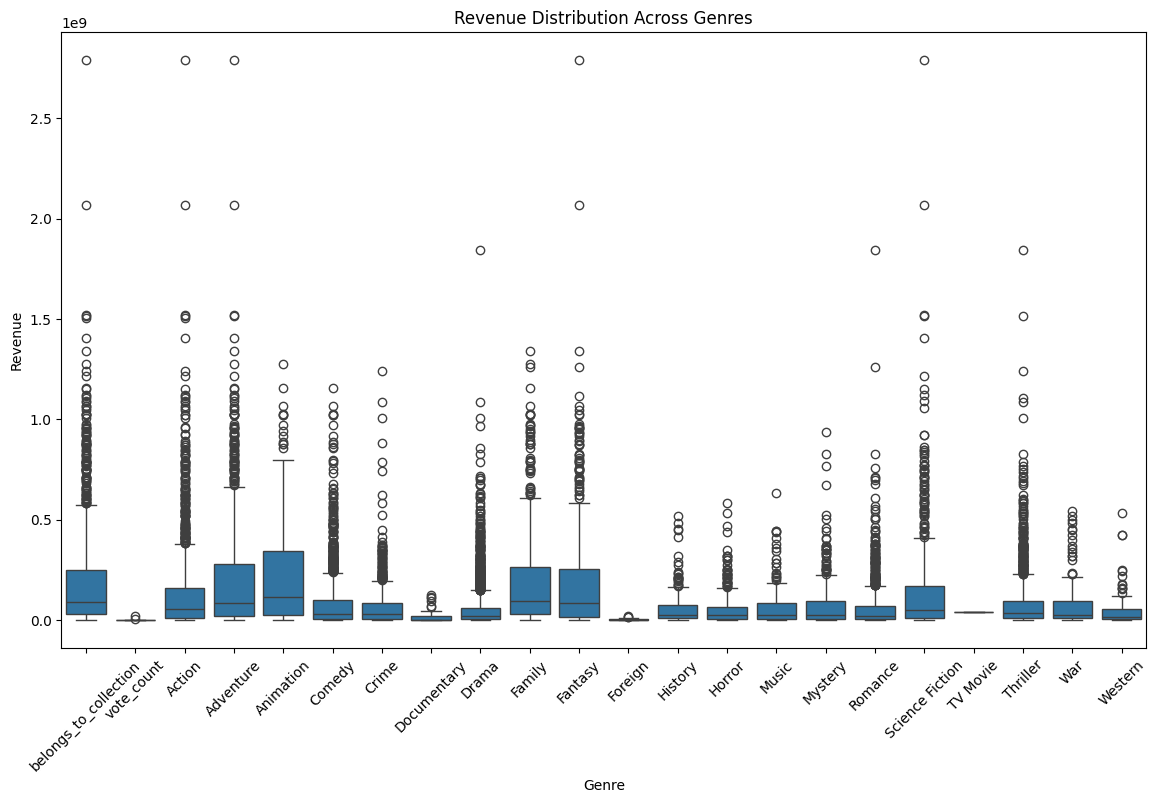

In [ ]:
# Revenue Distribution across Genre
genre_columns = df.columns[3:]
melted_df = df.melt(id_vars=['revenue'], value_vars=genre_columns, var_name='Genre', value_name='Present')
melted_df = melted_df[melted_df['Present'] == 1]

plt.figure(figsize=(14, 8))
sns.boxplot(data=melted_df, x='Genre', y='revenue')
plt.xticks(rotation=45)
plt.title('Revenue Distribution Across Genres')
plt.xlabel('Genre')
plt.ylabel('Revenue')
plt.show()

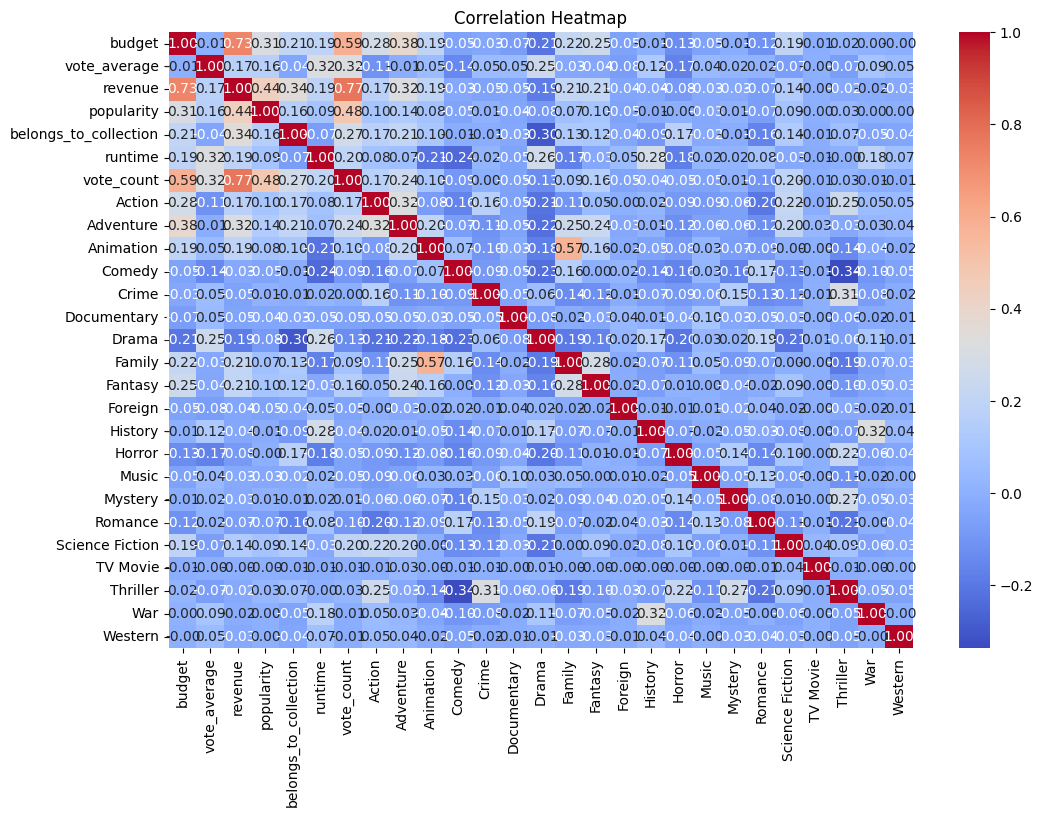

In [ ]:
# Correlation Heatmap
# Calculating correlation matrix for numeric columns
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Neural Network

In [ ]:
# Step 1: Load the Dataset
data = pd.read_csv("movies_metadata.csv")
data

<ipython-input-57-1be059de4719>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [ ]:
data = pd.read_csv("movies_metadata.csv", na_values=",,")

data['belongs_to_collection'].fillna("False", inplace=True)

<ipython-input-58-208a10f3df6f>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("movies_metadata.csv", na_values=",,")


In [ ]:
data = data.drop(columns=['homepage', 'poster_path', 'status', 'video', 'tagline', 'id', 'imdb_id', 'original_title', 'overview'])

In [ ]:
# Normalize/Standardize Data
scaler = StandardScaler()
numerical_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
data[numerical_cols] = data[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Drop rows containing NaN values in specified columns
data.dropna(subset=numerical_cols, inplace=True)

data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [ ]:
# Encode Categorical Variables
data['belongs_to_collection'] = data['belongs_to_collection'].apply(lambda x: 0 if x == "False" else 1)
data = pd.concat([data, data['genres'].str.get_dummies(sep=', ')], axis=1)
data = data.drop(columns=['genres'])

In [ ]:
data['revenue'] = pd.to_numeric(data['revenue'], errors='coerce')

data.dropna(subset=['revenue'], inplace=True)

In [ ]:
X = data.drop(columns=['revenue', 'production_companies', 'production_countries', 'spoken_languages', 'title', 'release_date','adult', 'original_language'])
y = data['revenue']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a PyTorch Dataset
class RevenueDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features)
        self.labels = torch.tensor(labels).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Convert DataFrame to NumPy arrays
X_train_np = X_train.values.astype(np.float32)
y_train_np = y_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
y_val_np = y_val.values.astype(np.float32)

# Create datasets
train_dataset = RevenueDataset(X_train_np, y_train_np)
val_dataset = RevenueDataset(X_val_np, y_val_np)

In [ ]:
# Define the Neural Network
class RevenuePredictor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RevenuePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
input_size = X_train.shape[1]
hidden_size = 64
model = RevenuePredictor(input_size, hidden_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
# Training loop
train_losses = []
val_losses = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/50], Train Loss: 0.3078, Val Loss: 0.2754
Epoch [2/50], Train Loss: 0.2044, Val Loss: 0.2436
Epoch [3/50], Train Loss: 0.1927, Val Loss: 0.2525
Epoch [4/50], Train Loss: 0.1841, Val Loss: 0.2412
Epoch [5/50], Train Loss: 0.1826, Val Loss: 0.2260
Epoch [6/50], Train Loss: 0.1764, Val Loss: 0.2350
Epoch [7/50], Train Loss: 0.1731, Val Loss: 0.2350
Epoch [8/50], Train Loss: 0.1700, Val Loss: 0.2242
Epoch [9/50], Train Loss: 0.1661, Val Loss: 0.2273
Epoch [10/50], Train Loss: 0.1716, Val Loss: 0.2251
Epoch [11/50], Train Loss: 0.1651, Val Loss: 0.2322
Epoch [12/50], Train Loss: 0.1647, Val Loss: 0.2412
Epoch [13/50], Train Loss: 0.1678, Val Loss: 0.2354
Epoch [14/50], Train Loss: 0.1554, Val Loss: 0.2216
Epoch [15/50], Train Loss: 0.1574, Val Loss: 0.2465
Epoch [16/50], Train Loss: 0.1586, Val Loss: 0.2119
Epoch [17/50], Train Loss: 0.1571, Val Loss: 0.2221
Epoch [18/50], Train Loss: 0.1559, Val Loss: 0.2600
Epoch [19/50], Train Loss: 0.1557, Val Loss: 0.2132
Epoch [20/50], Train 

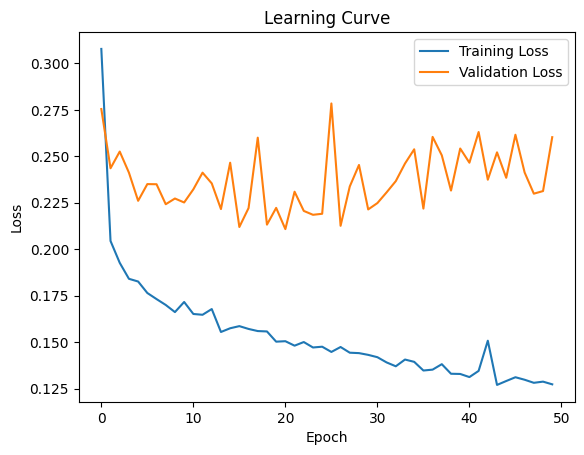

In [ ]:
# Plotting the learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [ ]:
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        predictions.extend(outputs.numpy())
        actuals.extend(targets.numpy())

predictions = np.array(predictions)
actuals = np.array(actuals)

mse = np.mean((predictions - actuals) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - actuals))

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.26029018
Root Mean Squared Error (RMSE): 0.51018643
Mean Absolute Error (MAE): 0.14088698


In [ ]:
r_squared = r2_score(actuals, predictions)
print("R-squared:", r_squared)

R-squared: 0.7839787913865122


In [ ]:
input_data = X.iloc[0]
input_tensor = torch.tensor(input_data, dtype=torch.float32)

model(input_tensor)

tensor([5.3842], grad_fn=<ViewBackward0>)

In [ ]:
sorted_df = data.sort_values(by='release_date')
sorted_df

,adult,belongs_to_collection,budget,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,...,{'id': 27,{'id': 28,{'id': 35,{'id': 36,{'id': 37,{'id': 53,{'id': 80,{'id': 878,{'id': 9648,{'id': 99
34940,False,0,-0.243169,xx,-0.408126,[],"[{'iso_3166_1': 'FR', 'name': 'France'}]",1874-12-09,-0.174752,-2.424747,...,0,0,0,0,0,0,0,0,0,0
34937,False,0,-0.243169,en,-0.433468,"[{'name': 'Palo Alto Stock Farm', 'id': 84748}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1878-06-14,-0.174752,-2.424747,...,0,0,0,0,0,0,0,0,0,0
41602,False,0,-0.243169,en,-0.449853,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1883-11-19,-0.174752,-2.424747,...,0,0,0,0,0,0,0,0,0,0
34933,False,0,-0.243169,xx,-0.291074,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1887-08-18,-0.174752,-2.424747,...,0,0,0,0,0,0,0,0,0,0
34934,False,0,-0.243169,xx,-0.452587,"[{'name': 'Whitley Partners', 'id': 48026}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1888-01-01,-0.174752,-2.424747,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45070,False,0,-0.243169,en,-0.487937,[],[],NaN,-0.174752,-2.450784,...,0,0,0,0,0,0,0,0,0,0
45148,False,0,-0.243169,ru,-0.487673,[],[],NaN,-0.174752,-0.471998,...,0,0,0,0,0,0,0,0,0,0
45203,False,0,-0.243169,en,-0.487900,[],[],NaN,-0.174752,-0.524071,...,0,0,0,0,0,0,0,1,0,0
45338,False,0,-0.243169,en,-0.487937,[],[],NaN,-0.174752,-2.450784,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sorted_df['release_date'] = pd.to_datetime(sorted_df['release_date'])

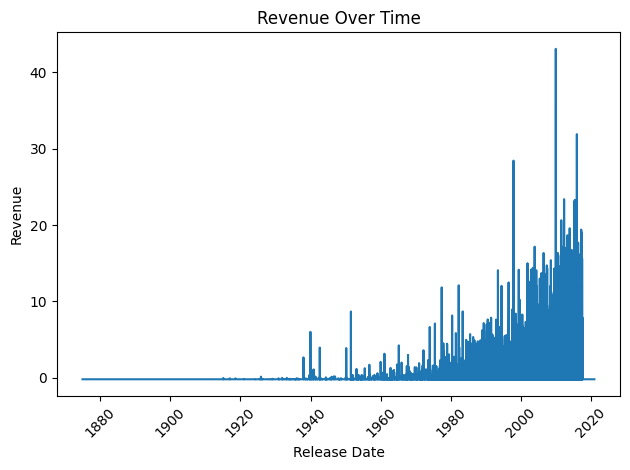

In [ ]:
release_dates = sorted_df['release_date']
revenue = sorted_df['revenue']

plt.plot(release_dates, revenue)
plt.xlabel('Release Date')
plt.ylabel('Revenue')
plt.title('Revenue Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

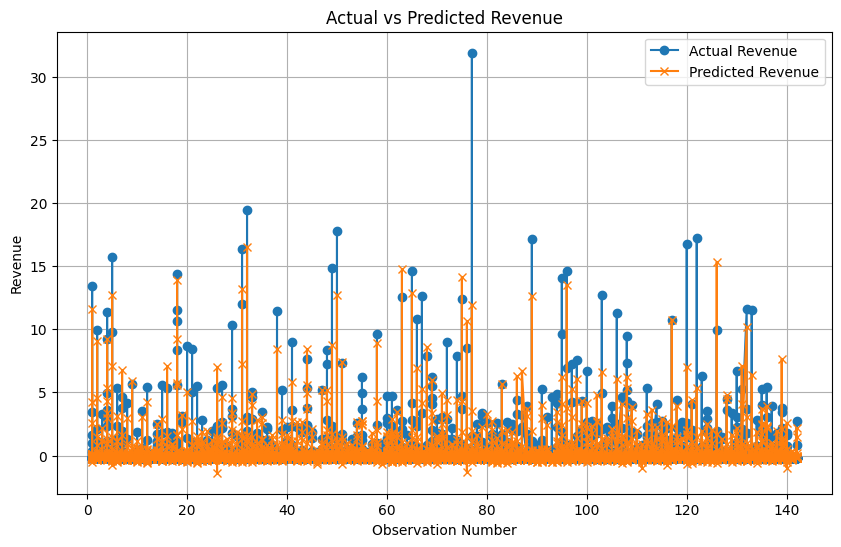

In [ ]:
model.eval()

predictions = []
actuals = []

observation_numbers = []

# Iterate through the validation data loader
with torch.no_grad():
    for i, (inputs, targets) in enumerate(val_loader, 1):
        outputs = model(inputs)

        predictions.extend(outputs.numpy())
        actuals.extend(targets.numpy())

        observation_numbers.extend(np.full(len(targets), i))

predictions = np.array(predictions)
actuals = np.array(actuals)
observation_numbers = np.array(observation_numbers)

plt.figure(figsize=(10, 6))
plt.plot(observation_numbers, actuals, label='Actual Revenue', marker='o')
plt.plot(observation_numbers, predictions, label='Predicted Revenue', marker='x')
plt.xlabel('Observation Number')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()
plt.grid(True)
plt.show()

Classification: KNN and Decision Tree

In [ ]:
# Reading in movie data
movies = pd.read_csv("movies_metadata.csv")

<ipython-input-77-646a064c44ed>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv")


In [ ]:
# Identifying and including the columns in the data relevant for classification
clf_dataset = movies[['adult', 'budget', 'original_language', 'revenue', 'runtime', 'status', 'vote_average']]

# Performing Imputation on the Dataset based on the Most Frequent Values
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputated_data = imp.fit_transform(clf_dataset)
clf_dataset = pd.DataFrame(imputated_data, columns=clf_dataset.columns)

# Encoding Each categorical column in the data using label encoding
categories = ['adult', 'original_language', 'status']
for column in categories:
        le = LabelEncoder()
        clf_dataset[column] = le.fit_transform(clf_dataset[column])


# Changing non-numeric values in budget column to Nan
clf_dataset['budget'] = pd.to_numeric(clf_dataset['revenue'], errors='coerce')

# Drop rows containing NaN values in the 'budget' column
clf_dataset.dropna(subset=['budget'], inplace=True)

In [ ]:
# Separating data into features and response. Creating bins based on vote averages to identify rating qualities (low, medium, high)
X = pd.DataFrame(clf_dataset.loc[:, clf_dataset.columns != 'vote_average'])
scaler = StandardScaler()
transformed_X = scaler.fit_transform(X)
# Separating Data Into Quantiles
low = clf_dataset['vote_average'].quantile(0.25)
high = clf_dataset['vote_average'].quantile(0.75)
Y = pd.cut(clf_dataset['vote_average'], bins=[min(clf_dataset['vote_average'])-1, low, high, max(clf_dataset['vote_average'])+1], labels=['low', 'medium', 'high'])

In [ ]:
# Lists of Metrics (+ K Values) That will Later Be Filled and converted into a dataframe
accuracies = {}
precisions = {}
recalls = {}
ks = []

# Scoring Metrics
scoring = ['accuracy', 'precision_macro', "recall_macro"]

# For K's 1-14, find the average accuracy, precision, and recall for each value of k using cross validation
for k in range(1, 15):
    ks.append(k)
    knn = KNeighborsClassifier(k)
    k_fold = KFold(shuffle=True, n_splits=5, random_state=0)
    scores = cross_validate(knn, transformed_X, Y, cv=k_fold, scoring=scoring, error_score='raise')
    accuracies[k] = np.mean(scores['test_accuracy'])
    precisions[k] = np.mean(scores['test_precision_macro'])
    recalls[k] = np.mean(scores['test_recall_macro'])

# Converting Metrics ( + K Values) to dataframe
knn_metrics = pd.DataFrame({'k': ks, 'accuracy': accuracies.values(), 'precision': precisions.values(), 'recall': recalls.values()})

# Examining Dataframe (7 is the optimal value of k when looking at recall)
knn_metrics

,k,accuracy,precision,recall
0,1,0.419391,0.384678,0.380582
1,2,0.366274,0.383507,0.386313
2,3,0.429706,0.399428,0.391284
3,4,0.422008,0.398214,0.398397
4,5,0.445938,0.406729,0.402094
5,6,0.448225,0.410249,0.402214
6,7,0.464215,0.416792,0.404999
7,8,0.457199,0.411554,0.400643
8,9,0.468878,0.418825,0.400967
9,10,0.469978,0.420068,0.401403


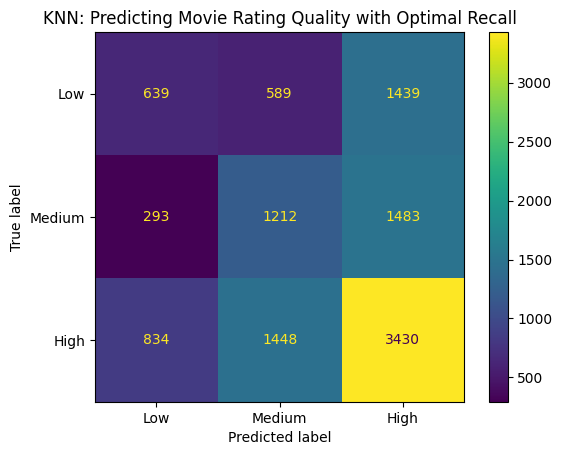

In [ ]:
# Splitting Data into Features and Response (75/25 Split)
X_train, X_test, Y_train, Y_test = train_test_split(transformed_X, Y, test_size=0.25, random_state=42)

# Creating KNN Model,  Fitting it To Train Data, and Making Predictions using X test data
knn = KNeighborsClassifier(7)
knn.fit(X_train, Y_train)
test_predictions = knn.predict(X_test)

# Creating Confusion Matrix and CM Display
cm = metrics.confusion_matrix(Y_test, test_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
display.plot()
plt.title('KNN: Predicting Movie Rating Quality with Optimal Recall')
plt.show()

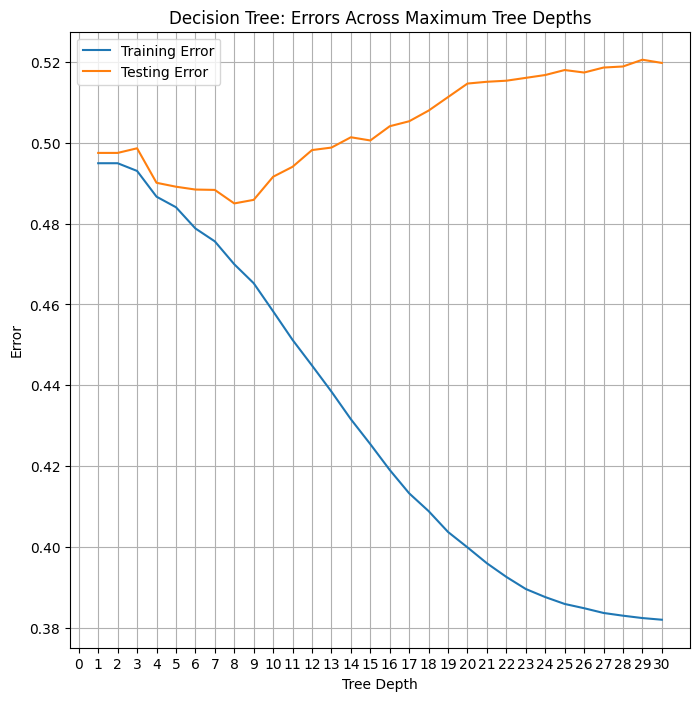

Best Maximum Depth: 8


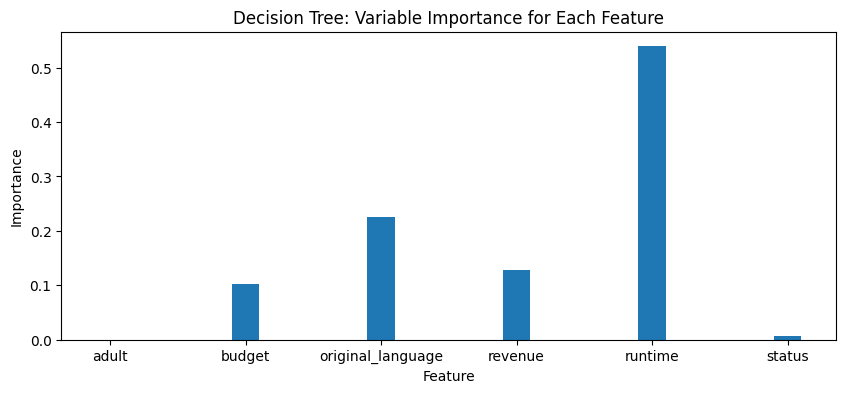

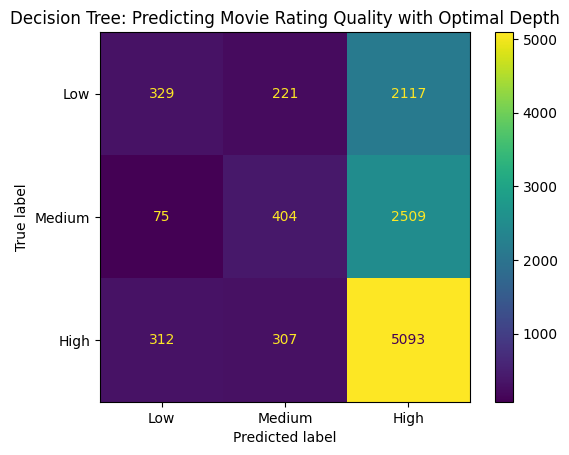

In [ ]:
# Setting Max_Depth Range to Iterate Through (1-30) and Creating Empty Lists of Training and Testing Errors
maximum_depth_range = range(1, 31)
training_errors = []
testing_errors = []

# Iterating Through depths in maximum depth range
for depth in maximum_depth_range:
    # Creating Decision Tree and Fitting it to Train Data
    decision_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=5)
    decision_tree.fit(X_train, Y_train)
    # Making predictions on test and train data
    test_predictions = decision_tree.predict(X_test)
    train_predictions = decision_tree.predict(X_train)
    # Computing Errors and Appending Them to Error Lists
    test_error = 1 - accuracy_score(Y_test, test_predictions)
    train_error = 1 - accuracy_score(Y_train, train_predictions)
    testing_errors.append(test_error)
    training_errors.append(train_error)

# Plotting Errors Across Maximum Tree Depths
plt.figure(figsize=(8, 8))
plt.plot(maximum_depth_range, training_errors, label='Training Error')
plt.plot(maximum_depth_range, testing_errors, label='Testing Error')
plt.xlabel('Tree Depth')
plt.ylabel('Error')
plt.title('Decision Tree: Errors Across Maximum Tree Depths')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(maximum_depth_range)-1, max(maximum_depth_range)+1, step=1))
plt.show()

# Printing Maximum Depth That Minimizes Error
print("Best Maximum Depth:", testing_errors.index(min(testing_errors))+1)

# Decision Tree with Information Gain Splitting Criteria (Default) (Best Depth)
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=5)
decision_tree.fit(X_train, Y_train)

# Making Test and Train Predictions
test_predictions = decision_tree.predict(X_test)
train_predictions = decision_tree.predict(X_train)

# Variable Importances of Decision Tree, Creating Empty Dictionary to Store These Importances
variable_importances = decision_tree.feature_importances_
variable_importances_dct = {}
index = 0

# Assign each feature as a key to the dictionary
for column_name in X.columns:
    variable_importances_dct[column_name] = variable_importances[index]
    index +=1

# Plotting Variable Importances Across Features
plt.figure(figsize=(10, 4))
plt.bar(variable_importances_dct.keys(), variable_importances_dct.values(), width = 0.2)
plt.title('Decision Tree: Variable Importance for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Importance')

# Creating Confusion Matrix and Display
cm = metrics.confusion_matrix(Y_test, test_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
display.plot()
plt.title('Decision Tree: Predicting Movie Rating Quality with Optimal Depth')
plt.show()